In [24]:
%matplotlib widget
import numpy as np
import os
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from textwrap import wrap

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')


def save_timescan_runlist(Loaddir, runlist, Delay_fs_TT, pp_TT, pp_fit=None, whichdiode="both_diodes"):
    """
    Guarda uno o varios runs de time scan en _single o _multiruns.

    Parameters
    ----------
    Loaddir : str
        Carpeta base (ej. /sf/alvra/data/p22588/work/Reduced_data/)
    runlist : list of int
        Lista de runs a guardar. Si es 1 run, se guarda en _single; si >1, en _multiruns.
    Delay_fs_TT : array
        Delays en fs.
    pp_TT : array
        Señal promedio ΔI/I.
    pp_fit : array, optional
        Fit de la traza.
    whichdiode : str
        Etiqueta del diodo.
    """
    
    if len(runlist) == 1:
        SaveDir = os.path.join(Loaddir, "_single")
    else:
        SaveDir = os.path.join(Loaddir, "_multiruns")

    # Nombre del run o concatenación de varios runs
    run_name = "_".join(str(r) for r in runlist)
    savedir = os.path.join(SaveDir, f"run{run_name}")
    os.makedirs(savedir, exist_ok=True)

    run_array = {}
    run_array[f"run{run_name}"] = {
        "name": f"run{run_name}",
        "Delay_fs": Delay_fs_TT,
        "pp_TT": pp_TT,
        "pp_fit": pp_fit
    }

    np.save(os.path.join(savedir, f'run_array_{whichdiode}.npy'), run_array)
    print(f"Time scan data saved in {savedir}/")


# Load data 

In [25]:
pgroup = 'p22591'
Loaddir_name = ''

runlist = [142]
#runlist = np.arange(205, 225)
t0_offsets = [0]*len(runlist)
#t0_offsets = [50, 20]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

In [99]:
#Plot_correlations_scan(pgroup, Loaddir, runlist, path='work/TestData', timescan=True, lowlim = 0.95)
#Plot_scan_2diodes(pgroup, Loaddir, runlist, path='work/TestData', timescan=True)

In [26]:
withTT    = False

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
#firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]

from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)
#acqlist = np.arange(1, len(scan.files))

data1, titlestring_stack1 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=False, t0_offset=t0_offsets)
data2, titlestring_stack2 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=True, t0_offset=t0_offsets)
Plot_reduced_data(data1, scan, titlestring_stack1, withTT)
Plot_reduced_data(data2, scan, titlestring_stack2, withTT)

readbacks = np.asarray(data1['readbacks'], dtype=object)

KeyError: 'units'

## [Average scans](#Averaged-scans)
## [Overlay curves](#Overlay-data)

# Average scans []

In [14]:
data1.keys()

dict_keys(['name', 'meta', 'pump_1', 'unpump_1', 'pump_2', 'unpump_2', 'pump_1_raw', 'unpump_1_raw', 'pump_2_raw', 'unpump_2_raw', 'Izero_pump', 'Izero_unpump', 'Delays_stage', 'arrTimes', 'Delays_corr', 'energy', 'scanvar', 'readbacks', 'corr1', 'corr2'])

In [15]:
len(data1['Delays_stage'])

15292

In [16]:
data1['arrTimes'][10]

np.float64(-20.79)

In [17]:
delays = sorted(data1['Delays_stage'])
steps = []
for d in delays:
    if not steps:
        steps.append(d)
    else:
        if abs(d-steps[-1])<=2:
            continue
        else:
            steps.append(d)

len(steps)

31

Time delay axis rebinned with delay stage data
0 shots out of 14304 survived (total shots: 15292)
Time delay axis rebinned with delay stage data
11573 shots out of 14304 survived (total shots: 15292)


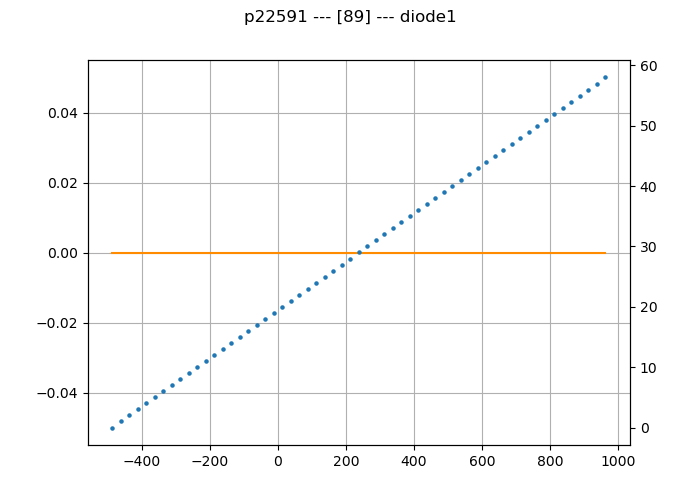

In [22]:
quantile = 0.9
binsize = 25
min_delay = -500
max_delay = 1000

(variable_bins, numbins)= (False, 100)
thresh=0
n_sigma=5
rawflag = True
####################################################################
####################################################################

results1 = Rebin_and_filter_timescans(data1, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma, rawflag, numbins, variable_bins)
results2 = Rebin_and_filter_timescans(data2, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma, rawflag, numbins, variable_bins)
plot_bins_population(results1, titlestring_stack1)

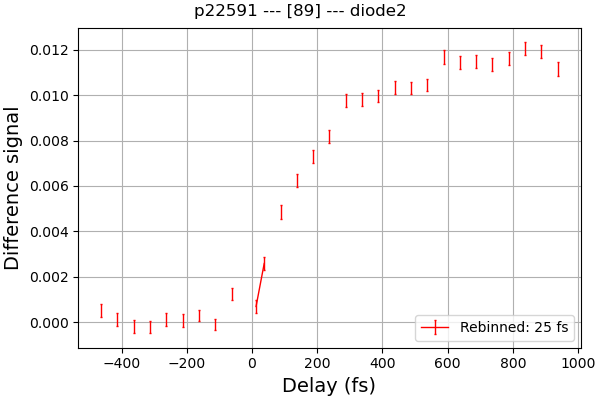

In [23]:
#pp_TT, Delay_fs_TT, pp_fit, indexNans = plot_kinetic_trace(results1, titlestring_stack1, binsize, withTT, fitflag=False) #errfunc_fwhm
pp_TT, Delay_fs_TT, pp_fit, indexNans = plot_kinetic_trace(results2, titlestring_stack2, binsize, withTT, fitflag=False) #errfunc_fwhm

# Avg diodes

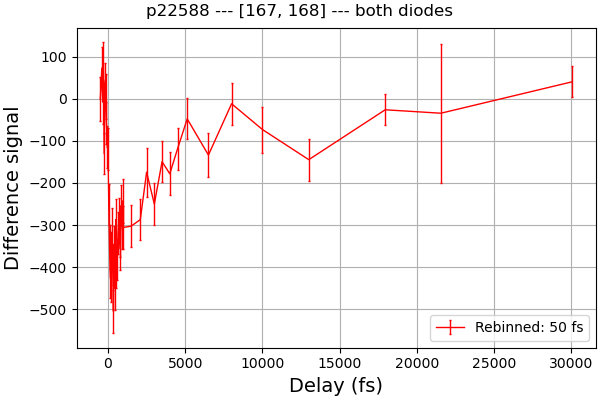

Time scan data saved in /sf/alvra/data/p22588/work/Reduced_data/_multiruns/run167_168/


In [103]:
results1_norm = normalize_spectra (results1)
results2_norm = normalize_spectra (results2)
results_ave, titlestring_ave = average_two_diodes(results1_norm, results2_norm, titlestring_stack1)
pp_TT, Delay_fs_TT, pp_fit, indexNans = plot_kinetic_trace(results_ave, titlestring_ave, binsize, withTT, fitflag=False) #errfunc_fwhm
save_timescan_runlist(Loaddir, runlist, Delay_fs_TT, pp_TT, pp_fit)

# Overlay

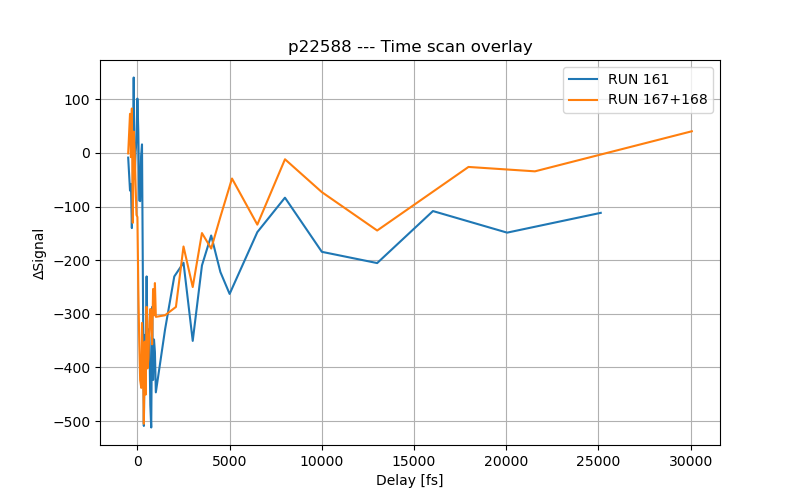

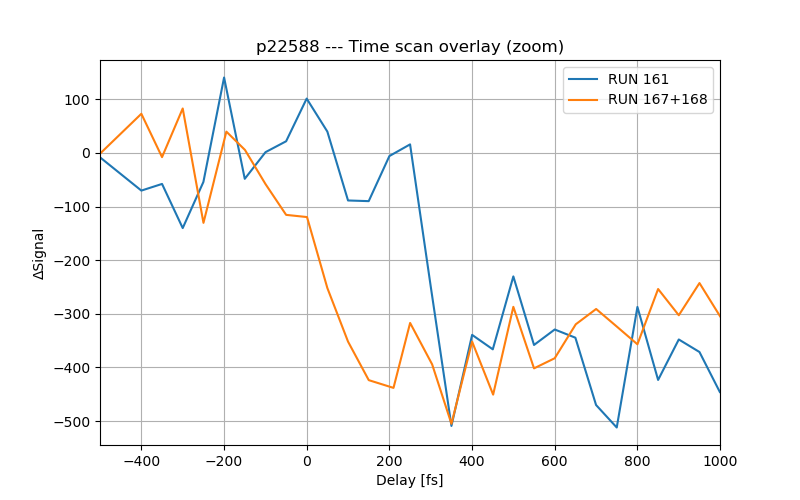

In [104]:
# ------------------- USER SETTINGS -------------------
#pgroup = 'p22588'
labdict = {'run161_161':'RUN 161', 'run167_168':'RUN 167+168'}
runlist2load = [[161,161], [167,168]]  # list of runs to overlay
Loaddir_folder = '_multiruns'  # '_single' or '_multiruns'
whichdiode = 'both_diodes'

Loaddir = f'/sf/alvra/data/{pgroup}/work/Reduced_data/{Loaddir_folder}/'
# -----------------------------------------------------
run_data_list = []
for run_group in runlist2load:
    run_name = "_".join(str(r) for r in run_group)  # e.g. '127_136'
    file_search = glob.glob(os.path.join(Loaddir, f'run{run_name}', f'run_array_{whichdiode}.npy'))
    
    if len(file_search) == 0:
        print(f"Run {run_name} missing!")
        continue

    data = np.load(file_search[0], allow_pickle=True).item()
    key = list(data.keys())[0]  # normally 'runXXX_YYY'
    run_data_list.append(data[key])

# ----------------- PLOT OVERLAY -----------------
plt.figure(figsize=(8,5))
for run_dict in run_data_list:
    name = run_dict['name']
    label = labdict.get(name, name)
    plt.plot(run_dict['Delay_fs'], run_dict['pp_TT'], label=label)
plt.xlabel("Delay [fs]")
plt.ylabel("ΔSignal")
plt.title(f"{pgroup} --- Time scan overlay")
plt.grid(True)
plt.legend()
plt.show()

# ----------------- PLOT ZOOM -----------------
plt.figure(figsize=(8,5))
for run_dict in run_data_list:
    name = run_dict['name']
    label = labdict.get(name, name)
    plt.plot(run_dict['Delay_fs'], run_dict['pp_TT'], label=label)
plt.xlabel("Delay [fs]")
plt.ylabel("ΔSignal")
plt.title(f"{pgroup} --- Time scan overlay (zoom)")
plt.xlim(-500, 1000)  # zoom en fs
plt.grid(True)
plt.legend()
plt.show()


In [74]:
# import pandas as pd
# outFiles = '/das/work/p21/p21960/excel_v2/'  #Location to save excel files
# ifSave = False
# suffix = '' continuous

# Delay_fs_TT, pp_TT
# if ifSave:
#     df = pd.DataFrame(np.vstack((Delay_fs_TT,pp_TT)).T, columns = ['Delay','Difference'])
#     fn = 'times_'+'_'.join([str(x) for x in runlist])+suffix+'.cs7100 to 7150 eVv'
#     df.to_csv(outFiles+fn, index = False)

# Fit risetime

In [75]:
from lmfit.models import PseudoVoigtModel

pp_TT_derivative = gaussian_filter1d(pp_TT, 1, order = 1)

mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=0.008, center= 0, sigma=1, fraction=0.5, x=Delay_fs_TT)

pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [-20, 0, 20, 0])

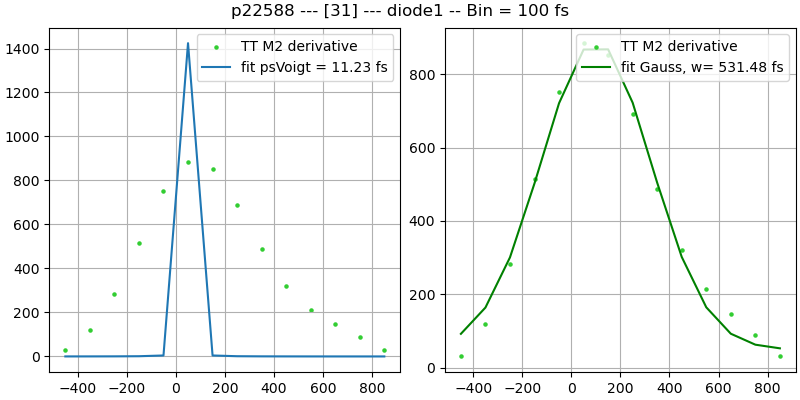

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
fig.suptitle(titlestring_stack1 + ' -- Bin = {} fs'.format(binsize))
ax1.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax1.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit psVoigt = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
ax1.grid()
ax1.legend(loc='upper right')

ax2.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax2.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'fit Gauss, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

ax2.legend(loc='upper right')
ax2.grid()
plt.show()

# FFT

35
95
(60,) (60,)


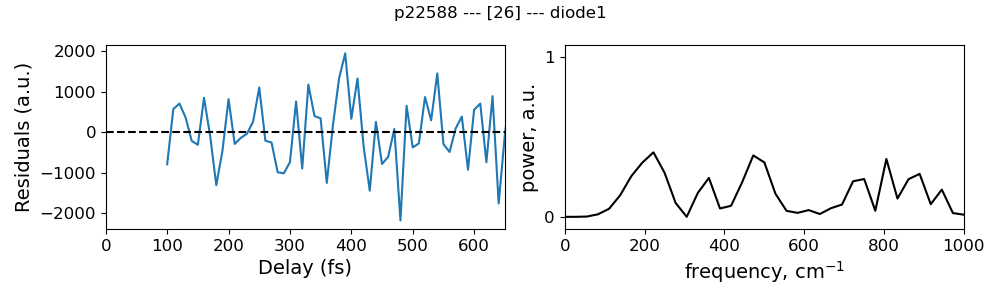

In [31]:
chosen_point_start = 100  #in fs
index_point_start = int(np.argwhere(Delay_fs_TT > chosen_point_start)[0])
print (index_point_start)

chosen_point_end = 700#in fs
index_point_end = int(np.argwhere(Delay_fs_TT > chosen_point_end)[0])
print (index_point_end)

transient = pp_TT[index_point_start:index_point_end]
x = Delay_fs_TT[index_point_start:index_point_end]

fit = pp_fit[index_point_start:index_point_end]

print(np.shape(transient), np.shape(x))
fitoutput = np.poly1d(np.polyfit(x, transient, 3))
pows = fitoutput(x)
transient2 = transient-pows
#transient2 = transient-fit
            
vals = np.hstack((transient2, np.zeros_like(transient2))) # pad
power = np.abs(np.fft.fft(vals))**2
frequencies = np.arange(0,0.999999999,1/len(vals))*16678*(2/binsize)

plt.figure(figsize=(10,3))
plt.suptitle(titlestring_stack1)
plt.subplot(121)

#plt.plot(np.arange(0, binsize*len(transient), binsize), transient)
plt.plot(chosen_point_start + np.arange(0, binsize*len(transient), binsize), transient2, '-')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Residuals (a.u.)', fontsize=14)
plt.xlabel('Delay (fs)', fontsize=14)
plt.xlim(0,650)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(122)
plt.plot(frequencies,power/np.max(power), '-', color='black')
plt.xlim(0,2200)
plt.xlabel('frequency, cm$^{-1}$', fontsize=14)
plt.ylabel('power, a.u.', fontsize=14)
plt.yticks([0,1])
plt.ylim(-0.075, 1.075)
plt.xlim(0,1000)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.vlines(1647, -0.1, 1.1, color='lightgrey', linestyle='dashed')
plt.tight_layout()

plt.show()
plt.savefig('/sf/alvra/data/p22285/work/Data_FePhen_p21992/XANES_fft.png', )

In [50]:
withTT    = False
switch_diodes = False

pgroup = 'p22588'
Loaddir_name = ''

runlist = [26]

jsonfile = get_json_from_run(runlist, pgroup)
scan = SFScanInfo(jsonfile[0])
acqlist = np.arange(1, len(scan.files))

#badrun = [113, 114]
#acqlist = np.setdiff1d(acqlist,badrun)

chunksize = len(acqlist)

quantile = 0.7

binsize = 100
min_delay = -500
max_delay = 1000

(variable_bins, numbins)= (False, 100)
thresh=0
####################################################
from lmfit.models import PseudoVoigtModel
acqchunks = np.resize(acqlist, (len(acqlist)//chunksize,chunksize))

Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
t0_fit = []
#w = []
t0_der = []
#w_der = []
t0_voigt = []
#w_voigt = []

for chunk in acqchunks:
    clear_output(wait=True)
    data = {}
    globals().update(data)
    
    data, titlestring_stack_loop = load_reduced_data_loop(pgroup, Loaddir, runlist, chunk)
    globals().update(data)
    print ('Run {}, acq {}, {} total on/off shots'.format(runlist, chunk, len(pump_1)))

    pump_1       = np.asarray(pump_1)
    unpump_1     = np.asarray(unpump_1)
    Izero_pump   = np.asarray(Izero_pump)
    Izero_unpump = np.asarray(Izero_unpump)
    Delays_stage = np.asarray(Delays_stage)
    arrTimes     = np.asarray(arrTimes)
    energy       = np.asarray(energy)
    Delays_corr  = np.asarray(Delays_corr)

    results = \
    Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma=5, raw=True)#, numbins, variable_bins)
    #Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, thresh, withTT, numbins, variable_bins)
    Delay_fs_TT = results['Delay']
    pp_TT       = results['pp']
    err_pp      = results['err_pp']
    
    fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    # Fit the curve with function chosen before
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 4, 1)# overwrite some values (index) if needed
    fit.p0 = better_p0(fit.p0, 0, 0)# overwrite some values (index) if needed
    
    fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fit.append(fit.popt[0])
    #w.append(np.abs(fit.popt[2]))
    
    pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 20, 0])
    t0_der.append(parameters_M2[0])
    #w_der.append(np.abs(parameters_M2[2]*2.355))

    ## Pseudo Voigt fit of the derivative
    mod = PseudoVoigtModel()
    pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
    init = mod.eval(pars, x=Delay_fs_TT)
    out = mod.fit(pp_TT_derivative, amplitude=0.0015, center= 0, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

    t0_voigt.append(out.params.get('center').value)
    #w_voigt.append(out.params.get('fwhm').value)
print ('----------------------------------')
#print ('Fit:  {} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_fit, decimals=2),np.nanmean(t0_fit), np.nanstd(t0_fit), binsize))
#print ('Gauss:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_der, decimals=2),np.nanmean(t0_der), np.nanstd(t0_der), binsize))
#print ('Voigt:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_voigt, decimals=2),np.nanmean(t0_voigt), np.nanstd(t0_voigt), binsize))
print ('Fit: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_fit), np.nanstd(t0_fit), binsize))
print ('Gauss: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_der), np.nanstd(t0_der), binsize))
print ('Voigt: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_voigt), np.nanstd(t0_voigt), binsize))

IndexError: list index out of range

NameError: name 'titlestring_stack_loop' is not defined

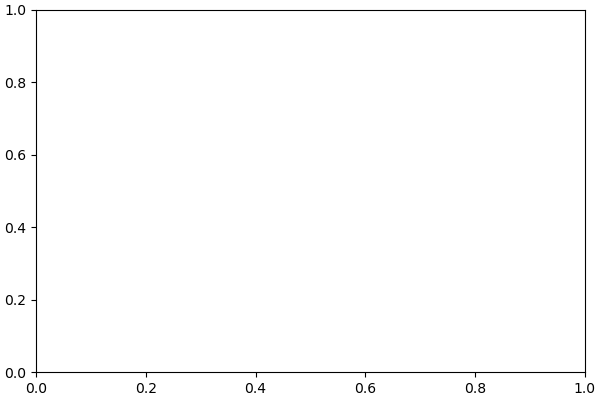

In [78]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(6,4))
plt.suptitle(titlestring_stack_loop)

label = 'Rebinned: {} fs'.format(binsize)
if withTT:
    label = 'TT corrected: {} fs'.format(binsize)

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label=label)
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,0)

    #p0 = [0, 100, 0, 200, 0]
    #popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    #pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    #t0_fs = popt[0]
    #width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs*2.355)))
    print("t0 = {:.4f} fs".format(t0_fs))
plt.grid()
plt.ylabel('Differential absorbance (OD)', fontsize=14)
plt.xlabel('Delay (fs)', fontsize=14)
plt.show()

#plt.savefig('/sf/alvra/data/p22285/work/Data_FePhen_p21992/XANES_oscill.png', )

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle('run {}'.format(runlist) + ' -- Chunksize={} -- Bin={} fs'.format(chuncksize, binsize))

ax1.plot(t0_fit, label='Fit')
ax1.plot(t0_der, label='Gauss der')
ax1.plot(t0_voigt, label='Voigt')
ax1.set_ylabel('width (fs)')
ax1.set_xlabel('chunk number')
ax1.legend(loc='best')
ax1.set_ylim(-100,100)
ax1.grid()
ax2.hist(t0_der, bins=100)
ax2.hist(t0_voigt, bins=100)
#ax2.set_xlim(0,1000)
ax2.grid()

# Fit decay constants

NameError: name 'titlestring_stack' is not defined

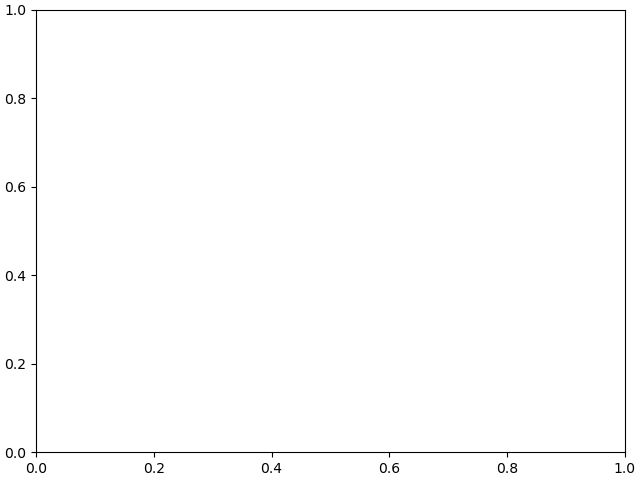

In [54]:
###################### 1 exp #################################
###   x0, sigma, amp1, tau1, C
p0 = [0,  100,   1,    1000, 1]
popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_1exp(Delay_fs_TT, *popt)

###################### 2 exp #################################
###   x0, sigma, amp1, tau1, C, amp2, tau2
p0 = [0,  200,   1,    1000, 1, 1,    10000]
popt,_  = curve_fit(model_decay_2exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_2exp(Delay_fs_TT, *popt)

###############################################################
fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(Delay_fs_TT, pp_TT)
plt.plot(Delay_fs_TT, y_fit)

popt = np.pad(popt, (0, 7-len(popt)), 'constant', constant_values=np.nan)
boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'IRF = {:.2f} fs'.format(np.abs(popt[1]*2.3548)),
                     r'tau1 = {:.2f} fs'.format(np.abs(popt[3])),
                     r'tau2  = {:.2f} fs'.format(np.abs(popt[6]))))
plt.text(0.6, 0.15, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.grid()
plt.tight_layout()
#plt.ylim(-0.25, 2)
plt.show()

#os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/{}.png'.format(ROI.split(':')[-1]))

## Overlay data

In [42]:
pgroup = 'p22588'

runlist = [51,45]
#runlist = [154, 225, 226]
Loaddir_folder = ''

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)
titlestring_overlay = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [51, 45] from /sf/alvra/data/p22588/work/Reduced_data//


['/sf/alvra/data/p22588/work/Reduced_data/run0051-PtLQ_timescan_2471p5eV/run_array.npy',
 '/sf/alvra/data/p22588/work/Reduced_data/run0045-PtLQ_timescan_2471p5eV/run_array.npy']

Time delay axis rebinned with delay stage data
44520 shots out of 88584 survived (total shots: 90532)
Time delay axis rebinned with delay stage data
42076 shots out of 80816 survived (total shots: 82783)


(-2000.0, 500.0)

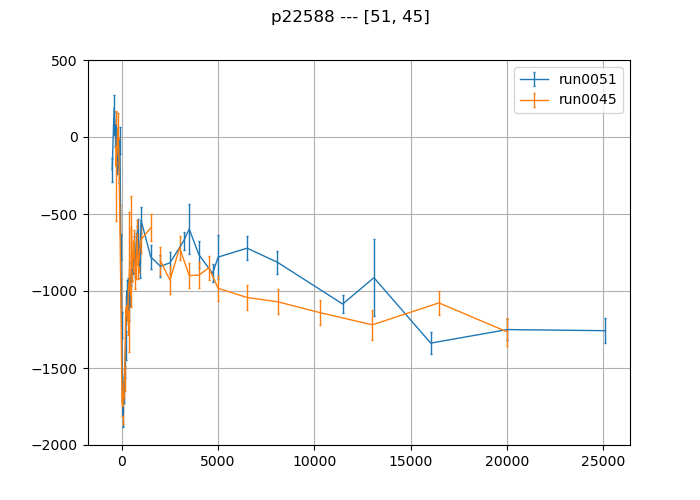

In [61]:
quantile = 0.7
switch_diodes = True    #False for Diode 1, True for diode 2
withTT = False

t0_offsets = [0]*len(runlist)

binsize = 100
min_delay = -300
max_delay = 35000

variable_bins=True
numbins=46

####################################################

fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=False)


lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    runname = 'run{:04d}'.format(run)
    data = {}
    t0_off = [t0_offsets[index]]
    data, _ = load_reduced_data(pgroup, Loaddir, [run], switch_diodes=False, t0_offset=t0_off)
    globals().update(data)
    
    results = \
    Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma, rawflag, numbins, variable_bins)#, numbins, variable_bins)
    
    Delay_fs_TT = results['Delay']
    # Delay_fs_TT = results['']
    pp_TT       = results['pp']
    err_pp      = results['err_pp']
    
    ax1.errorbar(Delay_fs_TT, pp_TT, err_pp, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+' '+str(lab[index]))

plt.suptitle(titlestring_overlay)
ax1.legend()
ax1.grid()
ax1.set_ylim(-2000,500)

In [28]:
Rebin_and_filter_timescans?

Signature:
Rebin_and_filter_timescans(
    data,
    binsize,
    minvalue,
    maxvalue,
    quantile,
    withTT,
    threshold=0,
    n_sigma=1,
    raw=True,
    numbins=None,
    varbin_t=False,
)
Docstring: <no docstring>
File:      /das/work/p22/p22588/anaconda/alvra-analysis-p22588/lib/python3.12/site-packages/alvra_tools/XAS_functions.py
Type:      function

## save the averaged spectra to load them overlaid

In [104]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Reduced_data/Timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

run_array = {}
run_array[run_name.split('-')[0]] = {"name": run_name,
                                    "Pump_probe_Diode1": pp_TT, 
                                    "errbars_pp": err_pp,
                                    "Delay_fs": Delay_fs_TT
                                    }
np.save(reducedir+run_name+'/run_array', run_array)

In [ ]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_1diode(reducedir, run_name, scan, 
                         average_array(DataDiode1_pump, 0), 
                         average_array(DataDiode1_unpump, 0), 
                         average_array(Pump_probe_Diode1, 0), 
                         average_array(goodshots1, 0),
                         average_array(correlation1, 0))
print (reducedir+run_name)

## save the averaged spectra to load them overlaid

In [7]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_2diodes(reducedir, run_name, scan, 
                          average_array(DataDiode1_pump, 0), 
                          average_array(DataDiode1_unpump, 0), 
                          average_array(Pump_probe_Diode1, 0), 
                          average_array(goodshots1, 0), 
                          average_array(correlation1, 0),
                          average_array(DataDiode2_pump, 0), 
                          average_array(DataDiode2_unpump, 0), 
                          average_array(Pump_probe_Diode2, 0), 
                          average_array(goodshots2, 0),
                          average_array(correlation2, 0))
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001
